# Gaussian Mixture Models on the Iris Dataset

This notebook demonstrates how to:

1. Load the real **Iris** dataset.
2. Standardize features.
3. Fit Gaussian Mixture Models (GMM) for different component counts.
4. Select the best number of components via **BIC**.
5. Evaluate the clustering with **Silhouette Score** and **Adjusted Rand Index**.
6. Visualize clusters and Gaussian ellipses in a 2‑D **PCA** space.


In [7]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA


In [8]:

# Load Iris and standardize
iris = load_iris(as_frame=True)
X_raw = iris.data
y_true = iris.target
target_names = iris.target_names

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
print(f"Data shape: {X.shape}")


Data shape: (150, 4)


In [9]:

# Fit GMMs with k = 1..6 and compute BIC
bic_scores, models = [], {}
for k in range(1, 7):
    gmm = GaussianMixture(n_components=k, covariance_type='full',
                          n_init=10, random_state=0)
    gmm.fit(X)
    bic_scores.append(gmm.bic(X))
    models[k] = gmm

best_k = int(np.argmin(bic_scores)) + 1
gmm_best = models[best_k]
labels = gmm_best.predict(X)

# Evaluation
sil = silhouette_score(X, labels)
ari = adjusted_rand_score(y_true, labels)
print(f"Best k = {best_k}, Silhouette = {sil:.2f}, ARI = {ari:.2f}")


Best k = 2, Silhouette = 0.58, ARI = 0.57


/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


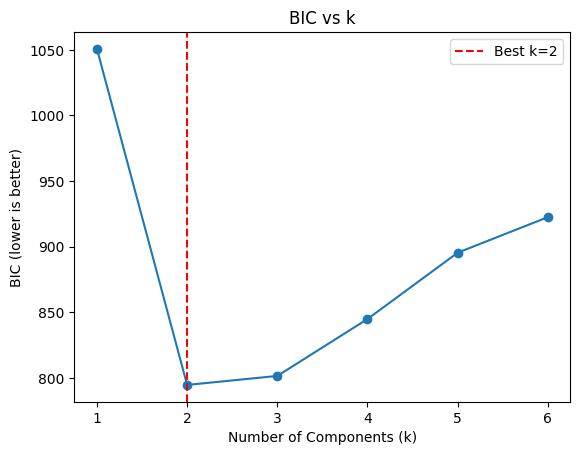

In [11]:

# Plot BIC curve
plt.figure()
plt.plot(range(1, 7), bic_scores, marker='o')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k={best_k}')
plt.xlabel('Number of Components (k)')
plt.ylabel('BIC (lower is better)')
plt.title('BIC vs k')
plt.legend()
plt.show()


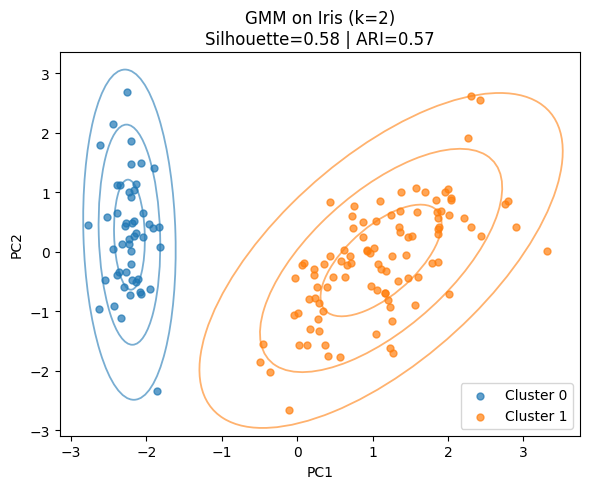

In [12]:

# PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

means_pca = pca.transform(gmm_best.means_)
covs_pca = [pca.components_ @ cov @ pca.components_.T for cov in gmm_best.covariances_]

def draw_ellipse(mean, cov, ax, color):
    # eigen‑decomposition
    U, s, _ = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)          # 1‑σ axis lengths
    for nsig in [1, 2, 3]:
        ell = Ellipse(
            mean,
            nsig * width,
            nsig * height,
            angle=angle,                    # ← pass as keyword
            edgecolor=color,
            facecolor="none",
            lw=1.3,
            alpha=0.6,
        )
        ax.add_patch(ell)

plt.figure(figsize=(6,5))
palette = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown']
for k in range(best_k):
    mask = labels == k
    plt.scatter(X_pca[mask,0], X_pca[mask,1],
                s=25, color=palette[k], label=f'Cluster {k}', alpha=0.7)
    draw_ellipse(means_pca[k], covs_pca[k], plt.gca(), palette[k])

plt.title(f'GMM on Iris (k={best_k})\nSilhouette={sil:.2f} | ARI={ari:.2f}')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()


/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/shiva/PycharmProjects/mlearn_poc/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_fi

NameError: name 'y' is not defined

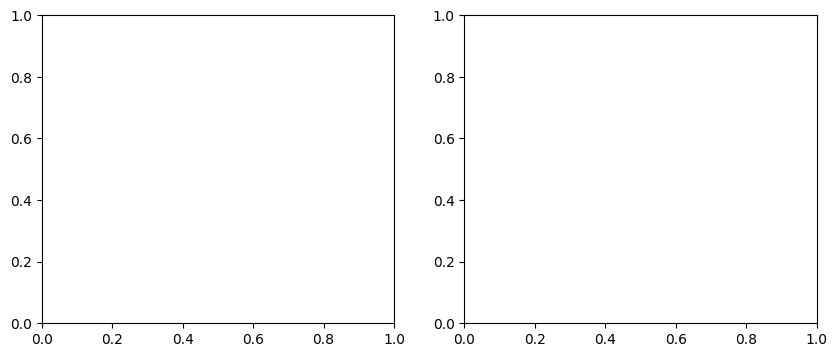

In [15]:
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# X, y = load_digits(return_X_y=True)
# X = StandardScaler().fit_transform(X)

# t‑SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X_pca)

# UMAP
u = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, random_state=0)
X_umap = u.fit_transform(X_pca)

fig, axes = plt.subplots(1,2, figsize=(10,4))
axes[0].scatter(X_tsne[:,0], X_tsne[:,1], c=y, s=5, cmap='tab10')
axes[0].set_title('t‑SNE')
axes[1].scatter(X_umap[:,0], X_umap[:,1], c=y, s=5, cmap='tab10')
axes[1].set_title('UMAP')
plt.tight_layout(); plt.show()
